In [2]:
# From regression.csv, generate a filtered valueble version.
# 1. For each buggy commit, search them in all the files, 

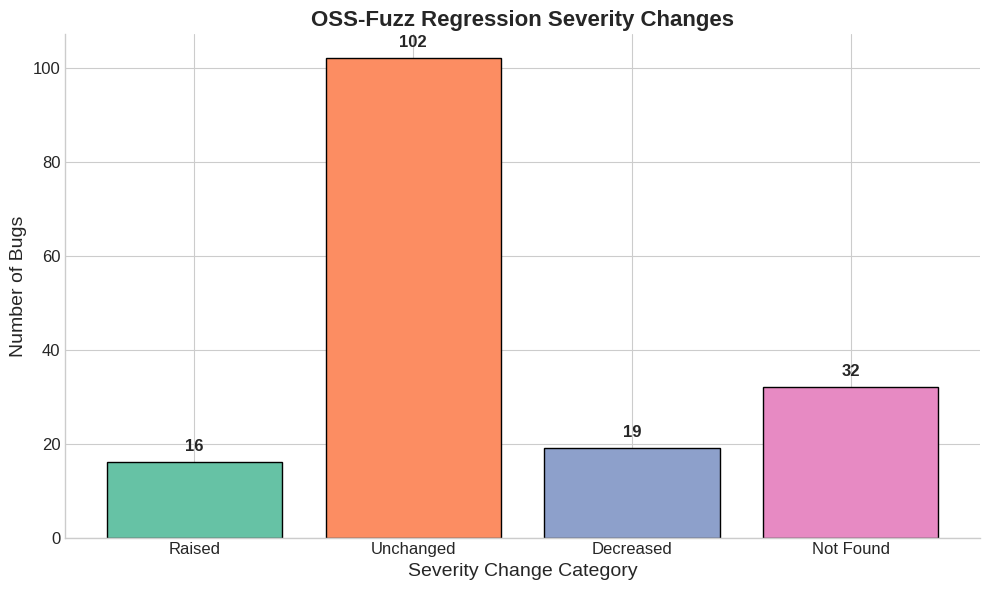

Severity raised: 16
Severity unchanged: 102
Severity decreased: 19
Severity not found: 32


In [ ]:

import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt

# Load data
csvpath = 'regression.csv'
df = pd.read_csv(csvpath)

# Extract severity
def extract_severity(yaml_file):
    try:
        with open(yaml_file, 'r') as file:
            data = yaml.full_load(file)
            for entry in data.get('affected', []):
                sev = entry.get('ecosystem_specific', {}).get('severity')
                if sev:
                    return sev.lower()
    except:
        pass
    return None

# Count changes
levels = {"low":1, "medium":2, "high":3, "critical":4}
raise_c = dec_c = unchg_c = notf_c = 0
for _, row in df.iterrows():
    s0 = extract_severity(row['fix0_file'])
    s1 = extract_severity(row['fix1_file'])
    if s0 and s1 and s0 in levels and s1 in levels:
        if levels[s1] > levels[s0]:
            raise_c += 1
        elif levels[s1] < levels[s0]:
            dec_c += 1
        else:
            unchg_c += 1
    else:
        notf_c += 1

# Plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

labels = ['Raised', 'Unchanged', 'Decreased', 'Not Found']
counts = [raise_c, unchg_c, dec_c, notf_c]
colors = plt.get_cmap('Set2')(range(len(labels)))

bars = ax.bar(labels, counts, color=colors, edgecolor='black', linewidth=1)

# Add labels on bars
for bar in bars:
    ax.annotate(bar.get_height(), 
                xy=(bar.get_x()+bar.get_width()/2, bar.get_height()), 
                xytext=(0,6), textcoords='offset points',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Titles and labels
ax.set_title("OSS-Fuzz Regression Severity Changes", fontsize=16, fontweight='bold')
ax.set_ylabel("Number of Bugs", fontsize=14)
ax.set_xlabel("Severity Change Category", fontsize=14)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# save pdf
plt.savefig('severity_change_analysis.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

print(f"Severity raised: {raise_c}")
print(f"Severity unchanged: {unchg_c}")
print(f"Severity decreased: {dec_c}")
print(f"Severity not found: {notf_c}")

/tmp/ipykernel_589014/3406754363.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3')


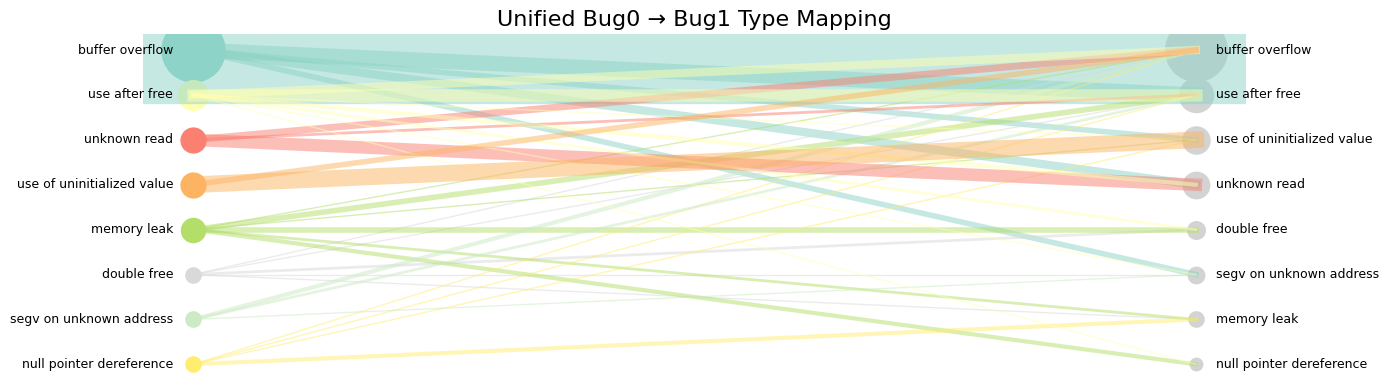

Same bug type count: 115
Total count: 203
Percentage of same bug types: 56.65%


In [5]:
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
import yaml
import os
import pandas as pd

# map bug types before and after regression
def extract_bug_type(yaml_file):
    try:
        with open(yaml_file, 'r') as file:
            data = yaml.full_load(file)
            summary = data.get('summary', []) # summary: Heap-buffer-overflow in op_Const64, I need the part before 'in'
            if isinstance(summary, str):
                # Extract the part before 'in'
                bug_type = summary.split(' in ')[0] if ' in ' in summary else summary
                return bug_type.lower()
    except Exception as e:
        print(f"Error reading {yaml_file}: {e}")
    return None

def unify_bug_type(bug_type: str) -> str:
    if pd.isna(bug_type):
        return None
    
    bug_type = bug_type.lower()
    if any(x in bug_type for x in ['buffer-overflow', 'buffer overflow', 'buffer underflow', 'param-overlap']):
        return 'buffer overflow'
    if any(x in bug_type for x in ['use-after-free', 'use after free', 'use-after-return']):
        return 'use after free'
    if 'uninitialized' in bug_type:
        return 'use of uninitialized value'
    if 'null-dereference' in bug_type or 'null dereference' in bug_type:
        return 'null pointer dereference'
    if 'double-free' in bug_type:
        return 'double free'
    if 'out-of-bounds' in bug_type:
        return 'out of bounds'
    if 'segv' in bug_type:
        return 'segv on unknown address'
    if 'unknown read' in bug_type:
        return 'unknown read'
    if 'unknown write' in bug_type:
        return 'unknown write'
    if 'bad-free' in bug_type:
        return 'bad free'
    if 'bad-cast' in bug_type:
        return 'bad cast'
    if 'security' in bug_type:
        return 'security exception'
    
    return bug_type.strip()

def prepare_combined_data(regression_csv, chains_csv):
    df1 = pd.read_csv(regression_csv)
    df1['bug0_types'] = df1['fix0_file'].apply(extract_bug_type).apply(unify_bug_type)
    df1['bug1_types'] = df1['fix1_file'].apply(extract_bug_type).apply(unify_bug_type)
    df1 = df1.dropna(subset=['bug0_types', 'bug1_types'])

    df2 = pd.read_csv(chains_csv)
    df2 = df2.dropna(subset=['bug0_types', 'bug1_types'])
    df2['bug0_types'] = df2['bug0_types'].str.lower().apply(unify_bug_type)
    df2['bug1_types'] = df2['bug1_types'].str.lower().apply(unify_bug_type)

    return pd.concat([df1[['bug0_types', 'bug1_types']], df2[['bug0_types', 'bug1_types']]], ignore_index=True)

def filter_rare_types(df, min_count=3):
    bug0_counts = df['bug0_types'].value_counts()
    bug1_counts = df['bug1_types'].value_counts()

    keep_bug0 = bug0_counts[bug0_counts >= min_count].index
    keep_bug1 = bug1_counts[bug1_counts >= min_count].index

    return df[df['bug0_types'].isin(keep_bug0) & df['bug1_types'].isin(keep_bug1)]


def generate_map(df):
    edge_counts = df.groupby(['bug0_types', 'bug1_types']).size().reset_index(name='count')
    bug0_counts = df['bug0_types'].value_counts()
    bug1_counts = df['bug1_types'].value_counts()
    bug0_list = list(bug0_counts.index)
    bug1_list = list(bug1_counts.index)

    pos0 = {bug: (0, i) for i, bug in enumerate(bug0_list)}
    pos1 = {bug: (1, i) for i, bug in enumerate(bug1_list)}

    cmap = cm.get_cmap('Set3')
    colors = {bug: cmap(i / max(1, len(bug0_list) - 1)) for i, bug in enumerate(bug0_list)}

    plt.figure(figsize=(14, max(len(bug0_list), len(bug1_list)) * 0.5))
    ax = plt.gca()

    for _, row in edge_counts.iterrows():
        bug0, bug1 = row['bug0_types'], row['bug1_types']
        x0, y0 = pos0[bug0]
        x1, y1 = pos1[bug1]
        ax.plot([x0, x1], [y0, y1], linewidth=row['count'], alpha=0.5, color=colors[bug0])

    for bug, cnt in bug0_counts.items():
        x, y = pos0[bug]
        ax.scatter(x, y, s=cnt * 20, color=colors[bug])

    for bug, cnt in bug1_counts.items():
        x, y = pos1[bug]
        ax.scatter(x, y, s=cnt * 20, color='lightgray')

    for bug in bug0_list:
        x, y = pos0[bug]
        ax.text(x - 0.02, y, bug, ha='right', va='center', fontsize=9)

    for bug in bug1_list:
        x, y = pos1[bug]
        ax.text(x + 0.02, y, bug, ha='left', va='center', fontsize=9)

    ax.invert_yaxis()
    ax.axis('off')
    plt.title('Unified Bug0 → Bug1 Type Mapping', fontsize=16)
    plt.tight_layout()
    plt.show()

def calculate_same_bug_type(df):
    same = (df['bug0_types'] == df['bug1_types']).sum()
    total = len(df)
    print(f"Same bug type count: {same}")
    print(f"Total count: {total}")
    print(f"Percentage of same bug types: {same / total * 100:.2f}%")

regression_csv = 'regression.csv'
chains_csv = 'memory_related_chains_all_source.csv'
combined_df = prepare_combined_data(regression_csv, chains_csv)
filtered_df = filter_rare_types(combined_df, min_count=3)

generate_map(filtered_df)
calculate_same_bug_type(combined_df)

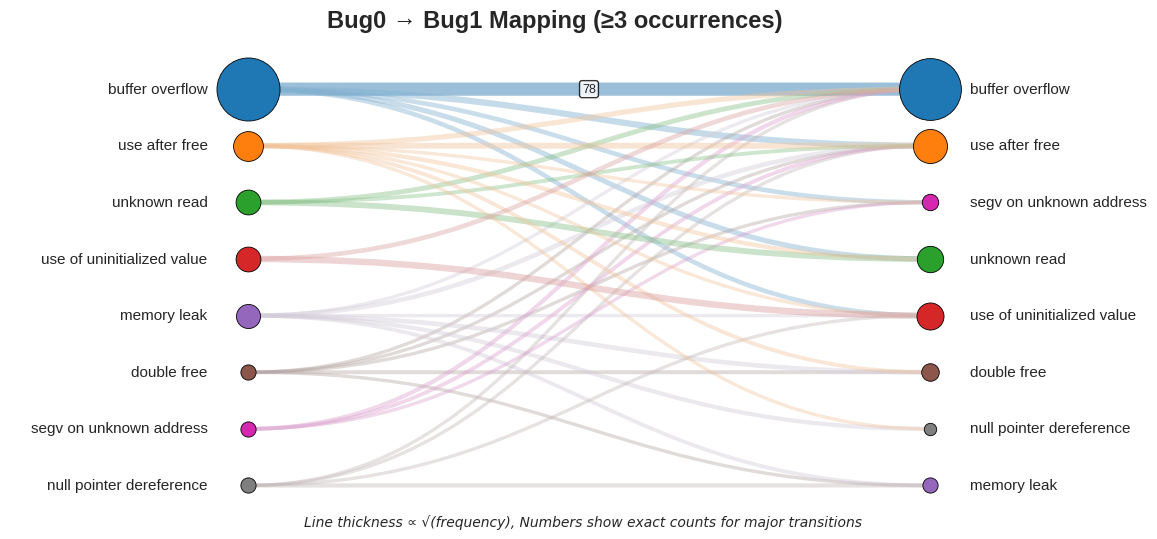

Same-type transitions : 113
Total transitions     : 191
Percentage identical  : 59.16 %

=== Bug Type Transition Statistics ===
Bug0 → Bug1                                        Count    Percentage
----------------------------------------------------------------------
buffer overflow → buffer overflow                  78       40.8    %
use of uninitialized value → use of uninitialized value 12       6.3     %
buffer overflow → use after free                   11       5.8     %
unknown read → unknown read                        9        4.7     %
use after free → use after free                    9        4.7     %
use after free → buffer overflow                   6        3.1     %
buffer overflow → unknown read                     6        3.1     %
unknown read → buffer overflow                     5        2.6     %
buffer overflow → segv on unknown address          4        2.1     %
memory leak → use after free                       4        2.1     %
buffer overflow → use of 

In [79]:
# ------------------------------------------------------------
#  Regression-chain bug-type mapping (colour-blind friendly)
# ------------------------------------------------------------
import os, yaml, colorsys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import matplotlib.path as mpath
import seaborn as sns
import numpy as np

# ------------ helpers -------------------------------------------------
def extract_bug_type(yaml_file: str) -> str | None:
    """Return summary prefix ('Heap-buffer-overflow', …) from OSS-Fuzz YAML."""
    try:
        with open(yaml_file, "r") as f:
            data = yaml.full_load(f)
            summary = data.get("summary", "")
            return summary.split(" in ")[0].lower() if isinstance(summary, str) else None
    except Exception:
        return None


def unify_bug_type(bt: str | None) -> str | None:
    """Map many ASan strings to coarse buckets (buffer overflow, UAF, …)."""
    if bt is None or pd.isna(bt):
        return None
    bt = bt.lower()
    cond = lambda *words: any(w in bt for w in words)

    if cond("buffer-overflow", "buffer overflow", "buffer underflow", "param-overlap"):
        return "buffer overflow"
    if cond("use-after-free", "use after free", "use-after-return"):
        return "use after free"
    if "uninitialized" in bt:
        return "use of uninitialized value"
    if cond("null-dereference", "null dereference"):
        return "null pointer dereference"
    if "double-free" in bt:
        return "double free"
    if "out-of-bounds" in bt:
        return "out of bounds"
    if "segv" in bt:
        return "segv on unknown address"
    if "unknown read" in bt:
        return "unknown read"
    if "unknown write" in bt:
        return "unknown write"
    if "bad-free" in bt:
        return "bad free"
    if "bad-cast" in bt:
        return "bad cast"
    if "security" in bt:
        return "security exception"
    return bt.strip()


# ------------ data wrangling ------------------------------------------
def prepare_combined(reg_csv: str, chains_csv: str) -> pd.DataFrame:
    df1 = pd.read_csv(reg_csv)
    df1["bug0_types"] = (
        df1["fix0_file"].apply(extract_bug_type).apply(unify_bug_type)
    )
    df1["bug1_types"] = (
        df1["fix1_file"].apply(extract_bug_type).apply(unify_bug_type)
    )
    df1 = df1.dropna(subset=["bug0_types", "bug1_types"])

    df2 = pd.read_csv(chains_csv)
    df2 = df2.dropna(subset=["bug0_types", "bug1_types"])
    df2["bug0_types"] = df2["bug0_types"].str.lower().apply(unify_bug_type)
    df2["bug1_types"] = df2["bug1_types"].str.lower().apply(unify_bug_type)

    return pd.concat(
        [df1[["bug0_types", "bug1_types"]], df2[["bug0_types", "bug1_types"]]],
        ignore_index=True,
    )


def filter_rare(df: pd.DataFrame, min_count: int = 3) -> pd.DataFrame:
    """Keep only bug-types that appear at least `min_count` times on each side."""
    keep0 = df["bug0_types"].value_counts()[lambda s: s >= min_count].index
    keep1 = df["bug1_types"].value_counts()[lambda s: s >= min_count].index
    return df[df["bug0_types"].isin(keep0) & df["bug1_types"].isin(keep1)]


# ------------ plotting -------------------------------------------------
def faded(rgb: tuple[float, float, float], alpha: float = 0.35) -> tuple:
    """Return a lighter, desaturated version of `rgb` with given alpha."""
    r, g, b = rgb
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    light = min(1.0, l + 0.35)
    sat   = max(0.0, s - 0.4)
    rf, gf, bf = colorsys.hls_to_rgb(h, light, sat)
    return (rf, gf, bf, alpha)


def generate_map(df: pd.DataFrame, title: str | None = None) -> None:
    edges   = df.groupby(["bug0_types","bug1_types"]).size().reset_index(name="count")
    cnt_b0  = df["bug0_types"].value_counts()
    cnt_b1  = df["bug1_types"].value_counts()
    order_b0 = list(cnt_b0.index)

    # order bug1 by dominant source
    dominant = (edges.sort_values("count", ascending=False)
                     .drop_duplicates("bug1_types")
                     .set_index("bug1_types")["bug0_types"])
    order_b1 = sorted(cnt_b1.index, key=lambda b: order_b0.index(dominant[b]))

    pos0 = {b:(0,i) for i,b in enumerate(order_b0)}
    pos1 = {b:(1,i) for i,b in enumerate(order_b1)}

    # 使用更高对比度的调色板，并为特定bug类型指定颜色
    def get_high_contrast_palette(n_colors):
        """生成高对比度调色板"""
        if n_colors <= 10:
            # 使用tab10but调整顺序，把高对比度颜色放前面
            base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                          '#8c564b', '#d627b0', '#7f7f7f', '#bcbd22', '#17becf']
            return [base_colors[i] for i in range(n_colors)]
        else:
            return sns.color_palette("tab20", n_colors=n_colors)
    
    # 为特定bug类型指定高对比度颜色
    special_colors = {
        'segv on unknown address': '#d627b0',  # 亮粉色，高对比度
        'buffer overflow': '#1f77b4',          # 蓝色
        'use after free': '#ff7f0e',           # 橙色
        'unknown read': '#2ca02c',             # 绿色
        'use of uninitialized value': '#d62728', # 红色
        'memory leak': '#9467bd',              # 紫色
        'double free': '#8c564b',              # 棕色
        'null pointer dereference': '#7f7f7f', # 灰色
    }
    
    palette = get_high_contrast_palette(len(order_b0))
    node_col = {}
    for i, b in enumerate(order_b0):
        if b in special_colors:
            node_col[b] = special_colors[b]
        else:
            node_col[b] = palette[i]

    # 增加图表高度，给顶部和底部更多空间
    fig_h = max(len(order_b0), len(order_b1)) * 0.55 + 1.0  # 增加额外的高度
    fig, ax = plt.subplots(figsize=(12, fig_h))

    Path  = mpath.Path
    max_w = edges["count"].max()

    def tint(rgb, alpha=0.65):  # 稍微增加alpha值提高可见度
        if isinstance(rgb, str):  # 如果是十六进制颜色
            # 转换十六进制到RGB
            rgb = tuple(int(rgb[i:i+2], 16)/255.0 for i in (1, 3, 5))
        r,g,b = rgb
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        # 减少亮度调整，保持更多原始颜色特征
        rt,gt,bt = colorsys.hls_to_rgb(h, min(1,l+0.25), max(0.1,s-0.25))
        return (rt,gt,bt,alpha)

    # edges with better proportional representation
    for _,row in edges.iterrows():
        b0,b1,w = row
        x0,y0 = pos0[b0]; x1,y1 = pos1[b1]
        verts  = [(x0,y0),(0.46,y0),(0.54,y1),(x1,y1)]
        codes  = [Path.MOVETO]+[Path.CURVE4]*3
        
        # 使用平方根缩放，更好地反映比例关系
        lw = 1.5 + 8.0 * np.sqrt(w / max_w)  # 平方根缩放
        
        # 添加透明度基于权重
        base_alpha = 0.4 + 0.4 * (w / max_w)  # 权重越大越不透明
        
        edge_color = tint(node_col[b0], alpha=base_alpha)
        ax.add_patch(
            mpatch.PathPatch(Path(verts,codes), facecolor="none",
                             edgecolor=edge_color,
                             linewidth=lw, zorder=2)
        )
        
        # 为较粗的线条添加数值标签
        if w / max_w > 0.3:  # 只为权重较大的边添加标签
            mid_x, mid_y = 0.5, (y0 + y1) / 2
            ax.text(mid_x, mid_y, str(w), 
                   ha='center', va='center', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                   zorder=10)

    scale = 20

    for b, c in cnt_b0.items():
        ax.scatter(*pos0[b], s=c * scale, color=node_col[b],
                edgecolor="black", linewidth=0.6, zorder=5)
        
    for b, c in cnt_b1.items():
        base = node_col.get(b, (0.75, 0.75, 0.75))
        ax.scatter(*pos1[b], s=c * scale, color=base,
                edgecolor="black", linewidth=0.6, zorder=5)

    # labels
    for b in order_b0:
        ax.text(pos0[b][0]-0.06, pos0[b][1], b,
                ha="right", va="center", fontsize=11)
    for b in order_b1:
        ax.text(pos1[b][0]+0.06, pos1[b][1], b,
                ha="left",  va="center", fontsize=11)

    # 设置更宽松的边界，特别是垂直方向
    y_max = max(len(order_b0), len(order_b1)) - 1
    ax.set_xlim(-0.35, 1.25)  # 水平边界稍微扩大
    ax.set_ylim(y_max + 0.6, -0.6)  # 垂直边界更宽松，顶部和底部都留出空间
    
    ax.axis("off")
    ax.set_title(title or "Bug0 → Bug1 Mapping", fontsize=17, weight="bold", 
                 pad=20)  # 增加标题和图表之间的间距
    
    fig.text(0.5, 0.01, 
         'Line thickness ∝ √(frequency), Numbers show exact counts for major transitions',
         ha='center', va='bottom', fontsize=10, style='italic',
         fontname='DejaVu Sans')  # or 'Arial Unicode MS' if available

    
    fig.subplots_adjust(left=0.12, right=0.88, top=0.95, bottom=0.12)
    
    plt.tight_layout()
    plt.savefig("bug0_bug1_mapping.pdf", bbox_inches="tight", dpi=300)
    plt.show()


def show_transition_stats(df: pd.DataFrame) -> None:
    """显示详细的转换统计信息"""
    edges = df.groupby(["bug0_types","bug1_types"]).size().reset_index(name="count")
    edges_sorted = edges.sort_values("count", ascending=False)
    
    print("\n=== Bug Type Transition Statistics ===")
    print(f"{'Bug0 → Bug1':<50} {'Count':<8} {'Percentage':<10}")
    print("-" * 70)
    
    total = edges_sorted["count"].sum()
    for _, row in edges_sorted.head(15).iterrows():  # 显示前15个最频繁的转换
        transition = f"{row['bug0_types']} → {row['bug1_types']}"
        count = row['count']
        percentage = count / total * 100
        print(f"{transition:<50} {count:<8} {percentage:<8.1f}%")
    
    print(f"\nTotal transitions: {total}")
    
    # 显示每种bug类型作为源和目标的频次
    print(f"\n=== Bug Type Frequencies ===")
    cnt_b0 = df["bug0_types"].value_counts()
    cnt_b1 = df["bug1_types"].value_counts()
    
    all_types = set(cnt_b0.index) | set(cnt_b1.index)
    print(f"{'Bug Type':<30} {'As Source':<10} {'As Target':<10} {'Total':<10}")
    print("-" * 70)
    
    for bug_type in sorted(all_types):
        as_source = cnt_b0.get(bug_type, 0)
        as_target = cnt_b1.get(bug_type, 0)
        total_freq = as_source + as_target
        print(f"{bug_type:<30} {as_source:<10} {as_target:<10} {total_freq:<10}")


# ------------ stats ----------------------------------------------------
def same_bug_stats(df: pd.DataFrame) -> None:
    same = (df["bug0_types"] == df["bug1_types"]).sum()
    total = len(df)
    print(f"Same-type transitions : {same}")
    print(f"Total transitions     : {total}")
    print(f"Percentage identical  : {same/total*100:.2f} %")


# ------------ main -----------------------------------------------------
if __name__ == "__main__":
    OSSFuzz_csv = "memory_regression_OSSFuzz.csv"
    GitHub_csv = "memory_regression_GitHub.csv"

    if not (os.path.exists(OSSFuzz_csv) and os.path.exists(GitHub_csv)):
        raise FileNotFoundError("CSV files not found in current folder.")

    combined = prepare_combined(OSSFuzz_csv, GitHub_csv)
    filtered = filter_rare(combined, min_count=3)

    generate_map(filtered, title="Bug0 → Bug1 Mapping (≥3 occurrences)")
    same_bug_stats(filtered)
    
    show_transition_stats(filtered)

/tmp/ipykernel_589014/3316047152.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c')


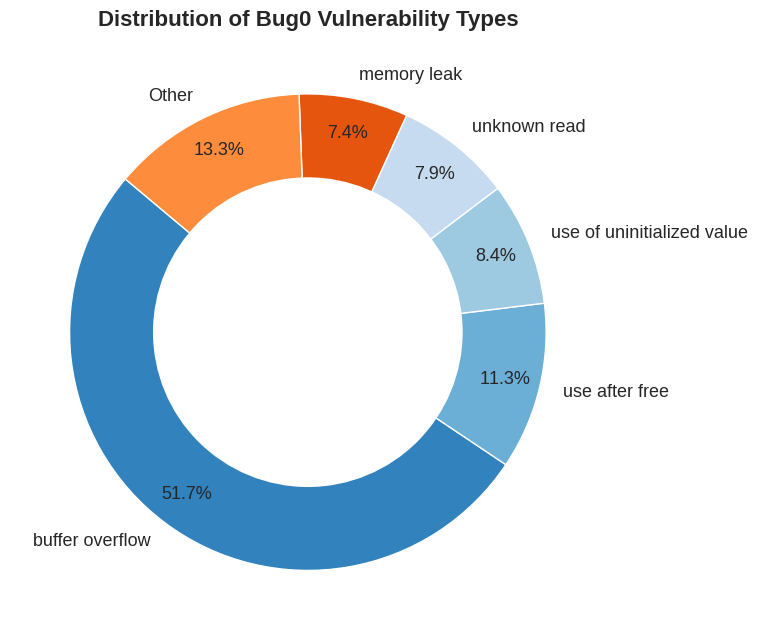

In [ ]:
def calculate_bug0_portion_from_df(df, threshold=0.03):
    bug0_counts = df['bug0_types'].value_counts()
    
    total = bug0_counts.sum()
    bug0_counts_filtered = bug0_counts[bug0_counts / total >= threshold]
    other = bug0_counts[bug0_counts / total < threshold].sum()
    if other > 0:
        bug0_counts_filtered['Other'] = other

    cmap = plt.cm.get_cmap('tab20c')
    colors = cmap(range(len(bug0_counts_filtered)))

    fig, ax = plt.subplots(figsize=(10, 6.5))
    wedges, texts, autotexts = ax.pie(
        bug0_counts_filtered,
        labels=bug0_counts_filtered.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 13},
        pctdistance=0.85
    )

    # Donut hole
    centre_circle = plt.Circle((0, 0), 0.65, fc='white')
    fig.gca().add_artist(centre_circle)

    ax.set_title('Distribution of Bug0 Vulnerability Types', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig('bug0_types_distribution.pdf', dpi=300, bbox_inches='tight', format='pdf')
    plt.show()


calculate_bug0_portion_from_df(filtered)   # or combined_df if unfiltered

/tmp/ipykernel_589014/3237783469.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20c')(range(len(bug0_counts_filtered)))


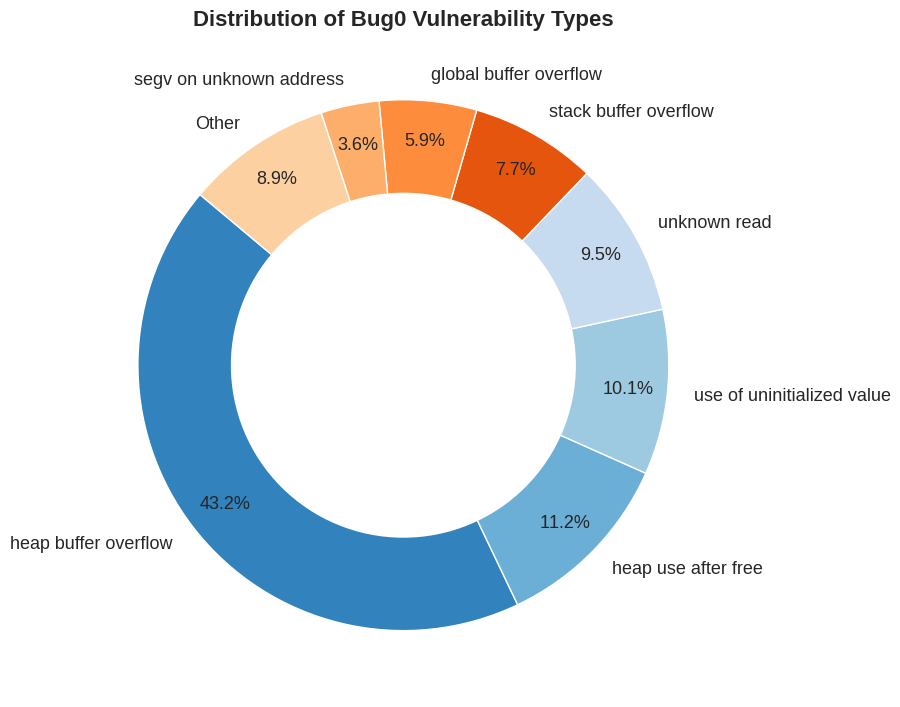

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def calculate_portion():
    csv_path = 'regression.csv'
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} invalid")
    
    df = pd.read_csv(csv_path)
    
    df['bug0_types'] = df['fix0_file'].apply(extract_bug_type)
    df['bug1_types'] = df['fix1_file'].apply(extract_bug_type)
    df = df.dropna(subset=['bug0_types', 'bug1_types'])
    df['bug0_types'] = df['bug0_types'].str.replace('-', ' ')
    df['bug1_types'] = df['bug1_types'].str.replace('-', ' ')

    bug0_counts = df['bug0_types'].value_counts()
    
    # Group small slices into "Other"
    threshold = 0.03  # Group bugs < 3%
    total = bug0_counts.sum()
    bug0_counts_filtered = bug0_counts[bug0_counts / total >= threshold]
    other = bug0_counts[bug0_counts / total < threshold].sum()
    if other > 0:
        bug0_counts_filtered['Other'] = other

    colors = plt.cm.get_cmap('tab20c')(range(len(bug0_counts_filtered)))

    fig, ax = plt.subplots(figsize=(9, 9))
    wedges, texts, autotexts = ax.pie(
        bug0_counts_filtered,
        labels=bug0_counts_filtered.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 13},
        pctdistance=0.85
    )

    # Draw white circle in the middle to make a donut chart
    centre_circle = plt.Circle((0, 0), 0.65, fc='white')
    fig.gca().add_artist(centre_circle)

    ax.set_title('Distribution of Bug0 Vulnerability Types', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig('bug0_types_distribution.pdf', dpi=300, bbox_inches='tight', format='pdf')
    plt.show()

calculate_portion()
